<font size="5">ライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import csv

<font size="5">cpuとgpuの選択

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "gpu")

<font size="5">乱数を特定の値にして再現性を確保

In [3]:
# For reproducibility
torch.manual_seed(42)
if use_cuda:
    torch.cuda.manual_seed(42)

<font size ="5">pytorch用データセットの作成

In [4]:
# Load MNIST dataset
# pytorchではTensorというデータ構造で、モデルの入力、出力、パラメータを表現
# 前処理の定義
"""
これから取得するDatasetの中身がndarray型のデータ集合であるため、前処理でtensor型にしたい

root
Datasetを参照(または保存)するディレクトリを「path」の部分に指定する.
そのディレクトリに取得したいDatasetが存在すればダウンロードせずにそれを使用する.

train
Training用のdataを取得するかどうかを選択する.
FalseにすればTest用のdataを取得するが,この2つの違いはdata数の違いと思ってくれて良い.

download
rootで参照したディレクトリにDatasetがない場合ダウンロードするかどうかを決めることができる.

transform
定義した前処理を渡す.
こうすることでDataset内のdataを参照する時にその前処理を自動で行ってくれる.
"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 学習用データとテスト用データの取得
# transformは私用すると前処理を指定できる
# これによりdatasetをdetaloaderに渡して使える状態にした
train_dataset_original = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
print(f"Train Dataset Size: {len(train_dataset_original)}")
test_dataset_original = datasets.FashionMNIST(root='./data', train=False, transform=transform)
print(f"Test Dataset Size: {len(test_dataset_original)}")

Train Dataset Size: 60000
Test Dataset Size: 10000


C:\Users\y9723\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<font size ="5">データの個数を調節

In [5]:
# traindata
# クラス数を取得
num_classes = len(train_dataset_original.classes)
print(num_classes)
print(len(train_dataset_original))
# 各クラスごとのデータ数を計算
desired_class_count = 3000  # 各クラスごとに均等に分割したいデータ数
total_desired_count = desired_class_count * num_classes

# クラスごとに均等にデータを分割するためのリストを作成
selected_indices_1 = []
selected_indices_2 = []

# 各クラスごとに均等にデータを選択
for class_idx in range(num_classes):
    class_indices = np.where(train_dataset_original.targets == class_idx)[0]
    np.random.shuffle(class_indices)
    selected_indices_1.extend(class_indices[:desired_class_count])
    selected_indices_2.extend(class_indices[desired_class_count:2*desired_class_count])

# 選択したデータで新しいデータセットを作成
train_data_1 = torch.utils.data.Subset(train_dataset_original, selected_indices_1)
train_data_2 = torch.utils.data.Subset(train_dataset_original, selected_indices_2)

# # 各クラスごとの新しいデータ数を確認
class_counts_subset_1 = np.bincount([train_dataset_original.targets[i] for i in selected_indices_1])
class_counts_subset_2 = np.bincount([train_dataset_original.targets[i] for i in selected_indices_2])

print("データセット1の各クラスごとの新しいデータ数:", class_counts_subset_1)
print("データセット2の各クラスごとの新しいデータ数:", class_counts_subset_2)

# testdata
# 2. データセット内のクラスごとのサンプル数を確認
class_count = [0] * 10# 10はFashionMNISTのクラス数です
sample_indices = []
for i in range(len(test_dataset_original)):
    _, target = test_dataset_original[i]
    if class_count[target] < 100:  # 各クラスから100サンプルまで抽出
        sample_indices.append(i)
        class_count[target] += 1

# 3. 均等に抽出されたサンプルから新しいデータセットを構築
test_data = torch.utils.data.Subset(test_dataset_original, sample_indices)

# 新しいデータセットを使用して必要な処理を実行

for i in range(len(test_data)):
    if class_count[target] < 100:  # 各クラスから100サンプルまで抽出
        sample_indices.append(i)
        class_count[target] += 1

# 各クラスごとのサンプル数を出力
for i, count in enumerate(class_count):
    print(f"クラス {i}: {count} 個のサンプル")
    
print(f"testデータの数：{len(test_data)}")

10
60000
データセット1の各クラスごとの新しいデータ数: [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]
データセット2の各クラスごとの新しいデータ数: [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]
クラス 0: 100 個のサンプル
クラス 1: 100 個のサンプル
クラス 2: 100 個のサンプル
クラス 3: 100 個のサンプル
クラス 4: 100 個のサンプル
クラス 5: 100 個のサンプル
クラス 6: 100 個のサンプル
クラス 7: 100 個のサンプル
クラス 8: 100 個のサンプル
クラス 9: 100 個のサンプル
testデータの数：1000


<font size ="5">Siamese Network用MNISTデータセットクラスの作成

In [6]:
# Siamese Network用MNISTデータセットクラスの作成
class SiameseMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset=dataset
        self.length=len(self.dataset)
        self.pair_index=[]     # Siamese Net用画像ペアインデックス配列
        labels=[label for _, label in self.dataset]     # 入力されたデータセットからラベル情報のみ抽出
        positive_count=0     # positiveペアのカウント
        negative_count=0     # negativeペアのカウント
        random_index=np.arange(self.length)     # ？？？
        
        while positive_count + negative_count < self.length:
            np.random.shuffle(random_index)
            for i in np.arange(self.length):
                if labels[i]==labels[random_index[i]]:     # 画像ペアのラベルが等しい時（positive）
                    if positive_count<self.length/2:      # おそらく比率を同じにしたい？？
                        self.pair_index.append([i, random_index[i], 1])      # 要素の構成：[<画像1のインデックス>,<画像2のインデックス>,<posi:1/nega:0フラグ>]
                        positive_count+=1
                    else:
                        continue
                else:
                    if negative_count<self.length/2:
                        self.pair_index.append([i, random_index[i], 0])
                        negative_count+=1
                    else:
                        continue
#         print("com", self.pair_index)
    def __len__(self):
        return self.length

    def __getitem__(self, index):

        return self.dataset[self.pair_index[index][0]][0], self.dataset[self.pair_index[index][1]][0], torch.tensor(self.pair_index[index][2])

<font size ="5">Siamese Network学習用Dataset, DataLoaderの作成

In [7]:
batch_size=64
# 1 学習用
# train_dataset_1=SiameseMNIST(train_data_1) 
# train_data_learn=DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
# # # 2 写像用(領域作成用)
# # train_data_projection=DataLoader(train_data_2, batch_size=1, shuffle=True)
# 3 テスト用
# test_loader=DataLoader(test_data, batch_size=1, shuffle=True)

batch_size=64
train_dataset=SiameseMNIST(train_dataset_original) 
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_prime=DataLoader(train_dataset_original, batch_size=1, shuffle=False)

In [8]:
test_loader=DataLoader(test_data, batch_size=1, shuffle=False)

<font size ="5">ペア画像の確認

torch.Size([1, 28, 28])
y[0]=0
y[1]=1
y[2]=1
y[3]=1
y[4]=1
y[5]=1
y[6]=0
y[7]=0
y[8]=1
y[9]=0


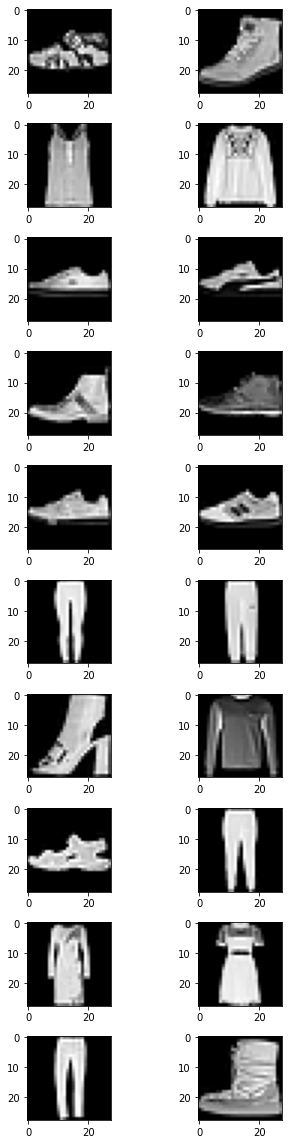

In [9]:
X1, X2, y = next(iter(train_loader))
print(X1[0].shape)
fig=plt.figure(tight_layout=True, figsize=(8, 16))
rows=10
for i in range(rows):
    print(f"y[{i}]={y[i]}")
    ax = fig.add_subplot(rows, 2, i*2+1)
    ax.imshow(X1[i][0].numpy(), cmap='gray')                          # X1[i].shape = (1, 28, 28)，X1[i][0].shape = (28, 28)
    ax = fig.add_subplot(rows, 2, i*2+2)
    ax.imshow(X2[i][0].numpy(), cmap='gray') 

<font size="5">モデルの構築

super()はあるクラス（子クラス）で別のクラス（親クラス）を継承できる。継承することで、親クラスのメソッドを子クラスから呼び出すことができる。
以下の形式
super().親クラスのメソッド

In [10]:
class BaseNetwork(nn.Module):
    """
    Base network for Siamese Network.
    This will be shared between two input images.
    """
    def __init__(self):
        super().__init__()

        # Define the layers
        # Using similar architecture as in the Keras example

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and Dense Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming input image size is 28x28
        self.act3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 256)
        self.act4 = nn.ReLU()

    def forward_1(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.dropout(x)
        x = self.fc2(x)
#         print("xのshape",x)
        x = self.act4(x)

        return x

    def forward(self, x1,x2):
        z1=self.forward_1(x1)
        z2=self.forward_1(x2)
        return z1,z2

# Test the base network with a sample input
base_network = BaseNetwork().to(device)
sample_input = torch.randn(8, 1, 28, 28).to(device)  # Batch of 8 images of sizammm28x28 with 1 channel
sample_output = base_network.forward_1(sample_input)

sample_output.shape  # Expected: [8, 256]


C:\Users\y9723\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([8, 256])

In [11]:
# Siamse Networkモデルクラス
import torch.nn as nn

class SiameseCNNMnistModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2), # 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2,2),                         # 14x14x32
            nn.Conv2d(32, 64, kernel_size=5, padding=2),# 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(2,2)                          # 7x7x64
        )

        # Fully connected layers to get embeddings
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
    
    def forward_once(self, x):
        x = self.encoder(x)
        x = x.view(x.size()[0], -1)  # Flatten
        z = self.fc(x)
        return z
  
    def forward(self, x1, x2):
        z1 = self.forward_once(x1)
        z2 = self.forward_once(x2)
        return z1, z2


<font size="5">損失関数

In [12]:
# 損失関数
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, y):
        difference = z1 - z2
        distance_squared = torch.sum(torch.pow(difference, 2), 1)
        distance = torch.sqrt(distance_squared)       #平均：0.813，最大：1.663，最小：0.023，中央値：0.492
        negative_distance = self.margin - distance
        negative_distance = torch.clamp(negative_distance, min=0.0)
        loss = (abs(y) * (distance_squared+2) + abs(1 - abs(y)) * torch.pow(negative_distance, 2)) / 2.0
        loss = torch.sum(loss) / z1.size()[0]
        return loss

<font size ="5">使用関数の一覧実行

<font size ="5">学習の準備

In [13]:
import torch.optim as optim
from torchsummary import summary

#モデルのインスタンス化
model=SiameseCNNMnistModel().to(device)
print(model.parameters)
# ？？？？
summary(model, input_size=[(1, 28, 28), (1, 28, 28)])      # 入力が２つあるので（ペア画像だから）input_sizeはリストで複数指定する

# 最適化関数の定義
optimizer=optim.SGD(model.parameters(), lr=0.05)

# 損失関数のインスタンス化
criterion=ContrastiveLoss()

<bound method Module.parameters of SiameseCNNMnistModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              

<font size ="5">学習の実行

In [14]:
# import copy
# import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

# # モデル学習
# repeat = 60                                                      # 学習回数
# losses = []                                                       # 表示用損失値配列

# model.train()                                                     # 学習モード
# for epoch in range(repeat): 
#   print(f"epoch={epoch}")
#   nan_count = 0
#   normal_count = 0




#   # tqdmを使って学習の進行状況を表示
#   for X1, X2, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{repeat}"):                                  
#     # モデルによる特徴ベクトル算出
#     output1, output2 = model(X1.to(device), X2.to(device))

#     # 損失関数の計算
#     loss = criterion(output1, output2, y.to(device))

#     # nan対策（lossにnanが含まれていれば１回前のモデルに戻す）
#     if torch.isnan(loss):
#       model = prev_model
#       optimizer = optim.SGD(model.parameters(), lr=0.05)
#       optimizer.load_state_dict(prev_optimizer.state_dict())
#       nan_count += 1
#       continue
#     else:
#       prev_model = copy.deepcopy(model)
#       prev_optimizer = copy.deepcopy(optimizer)
#       normal_count += 1

#     # 表示用lossデータの記録
#     losses.append(loss.item())

#     # 勾配を初期化
#     optimizer.zero_grad()
    
#     # 損失関数の値から勾配を求め誤差逆伝播による学習実行
#     loss.backward()
    
#     # 学習結果に基づきパラメータを更新
#     optimizer.step()

#   print(f"nan/normal: {nan_count}/{normal_count}")
# plt.plot(losses)                                                  # loss値の推移を表示


<font size ="5">学習結果の保存

In [15]:
# torch.save(model.state_dict(), 'model_weights_Epochs_60_Margin_2_5_Alpha_02.pth')

<font size ="5">学習済みの重みを再利用する場合

In [16]:
model.load_state_dict(torch.load('model_weights_epochs_60_margin_2.5.pth'))

<All keys matched successfully>

<font size ="5">モデルの出力ベクトルの取得

モデル学習の結果、同じクラスに属する画像の出力ベクトルは近くに、異なる数字に属する画像の出力ベクトルは遠くに配置されているはず。
これを確認するために、テストデータを用いて出力ベクトルを集める。
model.eval()で評価モードに設定し、変数の勾配も再計算されないようにtorch.no_grid()を記述する。

In [17]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_valid = []
    y_valid = []
    for X, y in train_loader_prime:                                      # テスト用DataLoader
        z_valid.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_valid.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_valid = torch.cat(z_valid, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_valid = torch.tensor(y_valid)                                 # スカラ要素(int)リストをtorch.tensor化

In [18]:
# 次元数の確認
print(z_valid.size())
print(y_valid.size())

torch.Size([60000, 3])
torch.Size([60000])


z_testとy_testをGPUに移動

In [19]:
# GPUが利用可能かチェック
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# z_validとy_validをGPUに移動
z_valid = z_valid.to(device)
y_valid = y_valid.to(device)
# ndarrayに変換
z_valid_np = z_valid.to('cpu').detach().numpy().copy()
y_valid_np = y_valid.to('cpu').detach().numpy().copy()
print(z_valid_np.shape)
print(y_valid_np.shape)

(60000, 3)
(60000,)


<font size="5">モデル出力ベクトルの分布可視化

<IPython.core.display.Javascript object>


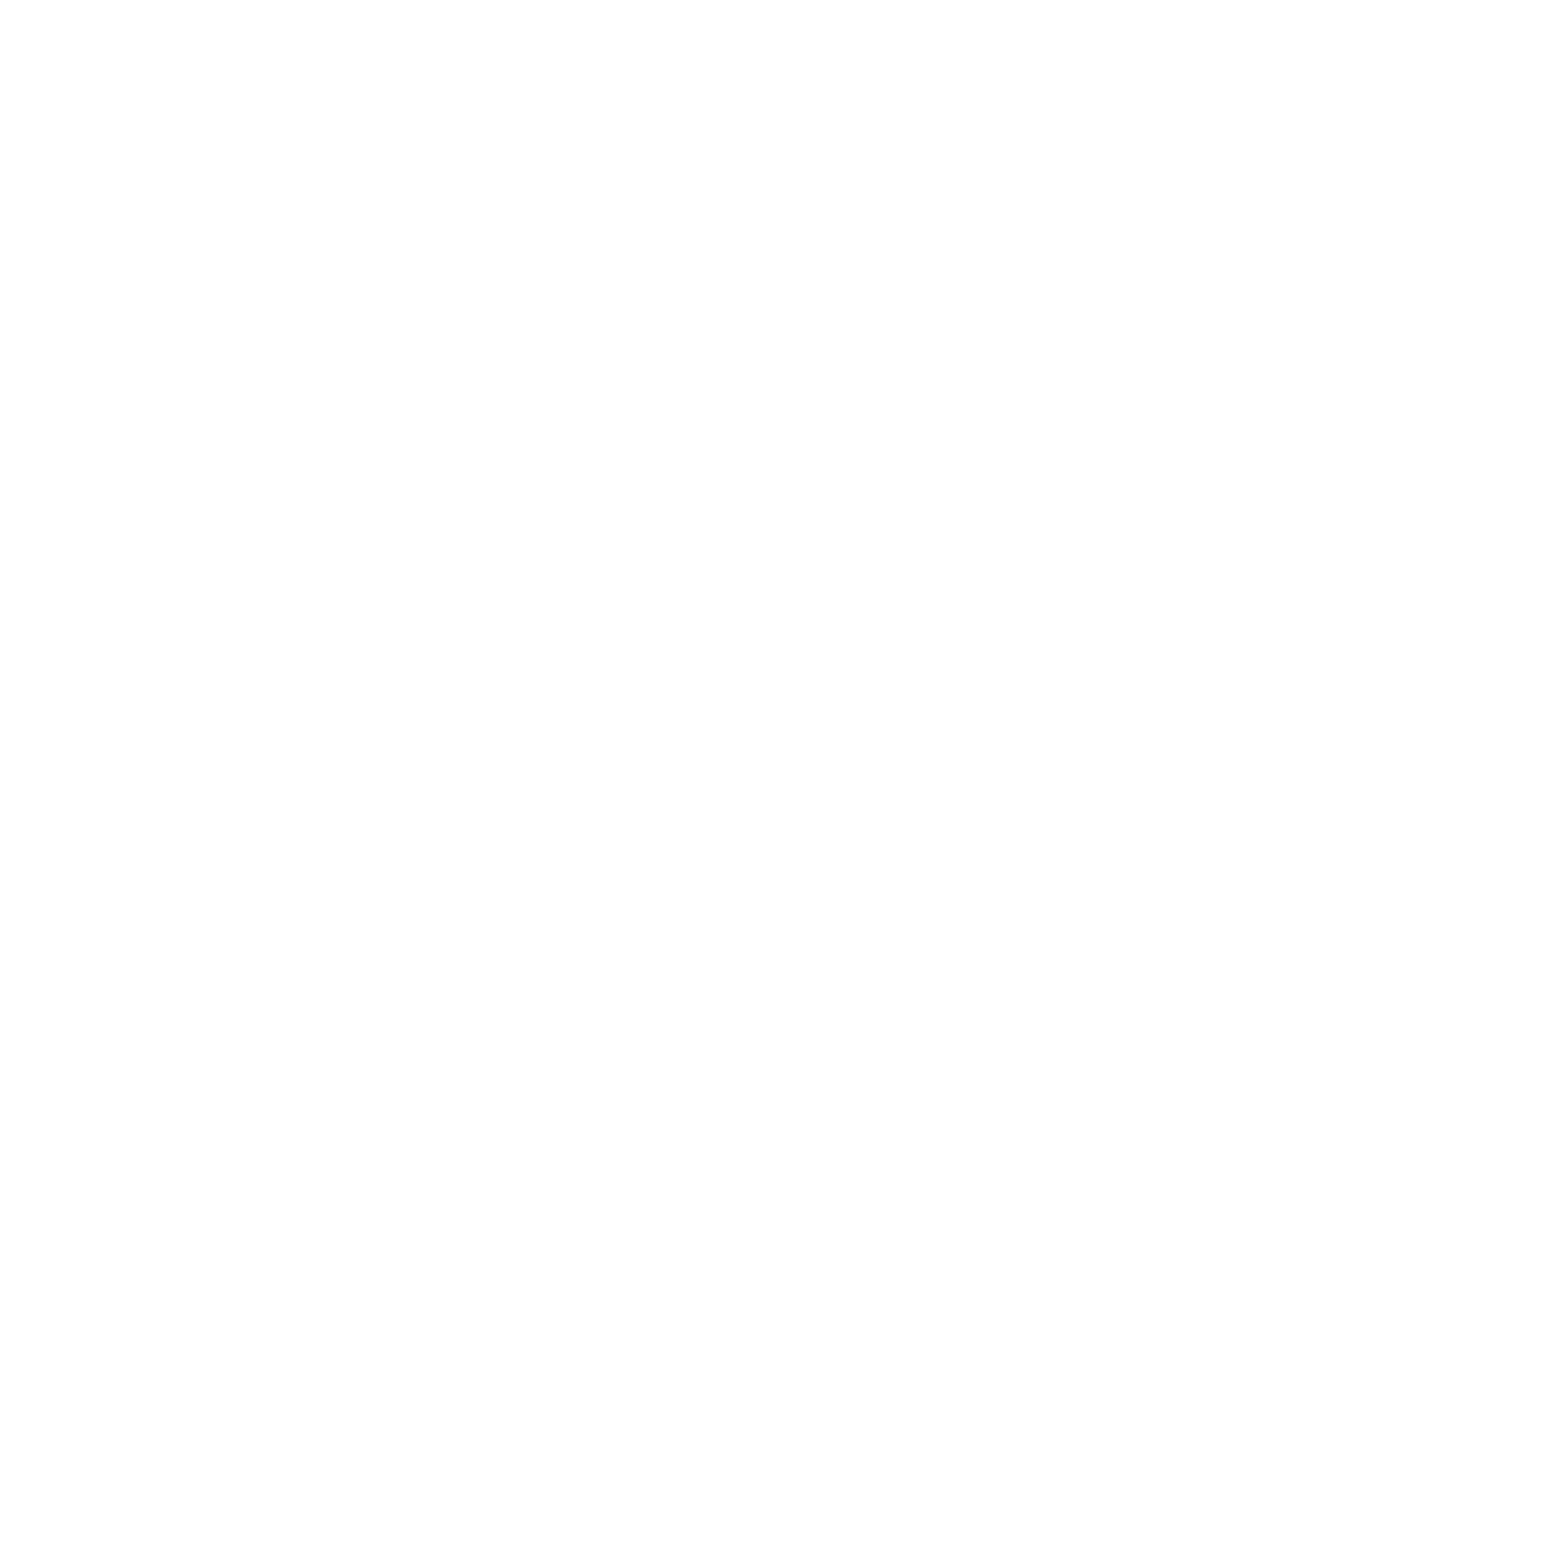

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# クラス数
class_num=len(class_names)
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']
# figureを生成する
plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = plt.subplot(111, projection='3d')
# クラスごとに色を分けてプロット
for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i])
ax.legend()  # 凡例の追加
plt.show()

<font size="5">判定領域作成関数

判定領域作成のステップを以下に示す   
１．ノイズクラスタリングにより算出した重心を可視化→処理時間がかかるためデータ数を減らして行う？  
２．重心から領域を広げていく（同心円状に安全マージンの導入をしてみてもいいかも）  
３．重心内の含有量を算出し、一定値以上となった場合広げるのをやめる  
４．以上により三次元空間の判定領域を作成     
→同心円状の場合は、判定領域内かどうかは半径と点同士の距離を測定して算出が可能  

<font size="5">testデータで性能判定

1. CNNから(3,)の出力を受け取る
2, 各クラスタとの距離を算出して最小のものを選択→半径以内かどうか判定（二十判定、判定がない場合に予測不可とする）

In [24]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_test = []
    y_test = []
    for X, y in test_loader:                                      # テスト用DataLoader
#         print(X)
        print(y)
        z_test.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_test.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_test = torch.cat(z_test, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_test = torch.tensor(y_test)

# z_testとy_testをGPUに移動
z_test = z_test.to(device)
y_test = y_test.to(device)
# ndarrayに変換
z_test_np = z_test.to('cpu').detach().numpy().copy()
y_test_np = y_test.to('cpu').detach().numpy().copy()
print(z_test_np.shape)
print(y_test_np.shape)

tensor([9])
tensor([2])
tensor([1])
tensor([1])
tensor([6])
tensor([1])
tensor([4])
tensor([6])
tensor([5])
tensor([7])
tensor([4])
tensor([5])
tensor([7])
tensor([3])
tensor([4])
tensor([1])
tensor([2])
tensor([4])
tensor([8])
tensor([0])
tensor([2])
tensor([5])
tensor([7])
tensor([9])
tensor([1])
tensor([4])
tensor([6])
tensor([0])
tensor([9])
tensor([3])
tensor([8])
tensor([8])
tensor([3])
tensor([3])
tensor([8])
tensor([0])
tensor([7])
tensor([5])
tensor([7])
tensor([9])
tensor([6])
tensor([1])
tensor([3])
tensor([7])
tensor([6])
tensor([7])
tensor([2])
tensor([1])
tensor([2])
tensor([2])
tensor([4])
tensor([4])
tensor([5])
tensor([8])
tensor([2])
tensor([2])
tensor([8])
tensor([4])
tensor([8])
tensor([0])
tensor([7])
tensor([7])
tensor([8])
tensor([5])
tensor([1])
tensor([1])
tensor([2])
tensor([3])
tensor([9])
tensor([8])
tensor([7])
tensor([0])
tensor([2])
tensor([6])
tensor([2])
tensor([3])
tensor([1])
tensor([2])
tensor([8])
tensor([4])
tensor([1])
tensor([8])
tensor([5])
tens

tensor([8])
tensor([9])
tensor([1])
tensor([6])
tensor([7])
tensor([3])
tensor([0])
tensor([2])
tensor([6])
tensor([7])
tensor([1])
tensor([0])
tensor([0])
tensor([8])
tensor([5])
tensor([2])
tensor([6])
tensor([6])
tensor([6])
tensor([4])
tensor([1])
tensor([5])
tensor([9])
tensor([0])
tensor([2])
tensor([1])
tensor([6])
tensor([5])
tensor([0])
tensor([0])
tensor([3])
tensor([3])
tensor([3])
tensor([8])
tensor([1])
tensor([1])
tensor([8])
tensor([5])
tensor([7])
tensor([7])
tensor([8])
tensor([7])
tensor([2])
tensor([0])
tensor([7])
tensor([3])
tensor([8])
tensor([0])
tensor([9])
tensor([7])
tensor([6])
tensor([1])
tensor([2])
tensor([6])
tensor([4])
tensor([8])
tensor([0])
tensor([6])
tensor([3])
tensor([6])
tensor([8])
tensor([4])
tensor([0])
tensor([8])
tensor([9])
tensor([2])
tensor([4])
tensor([5])
tensor([9])
tensor([1])
tensor([4])
tensor([4])
tensor([9])
tensor([2])
tensor([1])
tensor([7])
tensor([9])
tensor([5])
tensor([8])
tensor([1])
tensor([7])
tensor([7])
tensor([1])
tens

<class 'numpy.ndarray'>
(1, 28, 28)
<class 'numpy.ndarray'>
(3,)


<IPython.core.display.Javascript object>


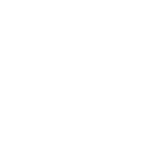

Label: 9


In [27]:
# 134番目の画像を取得
index = 0
image = test_loader.dataset[index][0]
label = test_loader.dataset[index][1]

# 画像を28x28からより小さなサイズに変更
npimg = image.numpy()
print(type(npimg))
print(npimg.shape)
print(type(z_test_np[134]))
print(z_test_np[134].shape)
npimg = npimg.reshape((28, 28))

# 図のサイズを設定
plt.figure(figsize=(1, 1))

# 出力画像の解像度を上げるためにinterpolationパラメータを指定
plt.imshow(npimg, cmap='gray', interpolation='bilinear')

print('Label:', label)
# print(y_test_np[134])
plt.show()  # 図を表示


<font size="5">testデータに対して判定領域を作成

判定領域作成のステップを以下に示す   
１．testデータを受け取る  
２．testデータからの距離（球、立方体）の領域を獲得、その条件に合うデータを取ってきて、ラベルを確認する  
３．ラベルから領域判定条件を設定する。し、解答を算出

In [39]:
## 距離関数
def calculate_distances(data1, data2):
    # data1 の各行と data2 とのユークリッド距離を計算
    distances = np.linalg.norm(data1 - data2, axis=1)

    return distances

def calculate_distances_normal(data1, data2):
    # numpyのユークリッド距離関数を使用して距離を計算
    distance = np.linalg.norm(data1 - data2)
    return distance

①normal

In [55]:
# 格納用
data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
level0=string_test_radius
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=60
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level0, level1]
# print(indices)

# データの整理

for index in range(len(test_radius)):
    for l in range(z_test_np.shape[0]):
        # new判定領域球の作成
        array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
        # 四角形内か否かを判定
#         array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
#         print(array)
#         array1=array.all(axis=1)
#         array1=array.all(axis=1)
#         print(array1.shape)
#         print(array1)
        array2=z_valid_np[array]   
#         print(array2.shape)
        # totalの計算
        total_elements=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array]
    #     print(type(array3))
        counts=np.bincount(array3, minlength=10)
        var_counts=np.copy(counts)
        # 結果の表示
        # 11/26：分散の導入
#         print(counts.shape)
        for i in range(class_num):
            var_counts=counts/variance[i]
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
    #         print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    #     print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
    #     print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
    #     print(f"max_index:{max_index}")
        if para < max_value and total_elements!=0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
        
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in longlong_scalars


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  Sneaker  \
0.1 正解             78       96        77     76    77      95     65       95   
    不正解            11        2        16     10    11       1     18        2   
    解答不可           11        2         7     14    12       4     17        3   
0.2 正解             84       98        79     79    78      99     69       96   
    不正解            10        1        15      9     9       0     15        3   
    解答不可            6        1         6     12    13       1     16        1   
0.3 正解             82       98        80     83    80     100     71       96   
    不正解            11        1        15      9     9       0     18        2   
    解答不可            7        1         5      8    11       0     11        2   
0.4 正解             83       98        80     85    83     100     71       96   
    不正解            10        1        15      7    10       0     20        2   
    解答不可            7        1         5      8     7       0      9        2   
0.5 正解             85       98        80     85    83     100     70       96   
    不正解            10        1        15      7    12       0     21        2   
    解答不可            5        1         5      8     5       0      9        2   
0.6 正解             84       99        80     85    83     100     68       96   
    不正解            11        1        15      6    11       0     21        2   
    解答不可            5        0         5      9     6       0     11        2   
0.7 正解             87       99        80     85    82     100     65       96   
    不正解            10        1        14      7    12       0     21        2   
    解答不可            3        0         6      8     6       0     14        2   
0.8 正解             87       99        80     85    79     100     64       96   
    不正解            10        1        13      6    11       0     21        3   
    解答不可            3        0         7      9    10       0     15        1   
1   正解             86       99        78     86    77     100     54       96   
    不正解            10        1        11      6     9       0     19        3   
    解答不可            4        0        11      8    14       0     27        1   

          Bag  Ankle boot  
0.1 正解     92          93  
    不正解     1           4  
    解答不可    7           3  
0.2 正解     97          96  
    不正解     1           4  
    解答不可    2           0  
0.3 正解     97          96  
    不正解     0           4  
    解答不可    3           0  
0.4 正解     97          95  
    不正解     2           4  
    解答不可    1           1  
0.5 正解     97          95  
    不正解     1           4  
    解答不可    2           1  
0.6 正解     97          96  
    不正解     2           4  
    解答不可    1           0  
0.7 正解     97          96  
    不正解     2           4  
    解答不可    1           0  
0.8 正解     97          96  
    不正解     1           4  
    解答不可    2           0  
1   正解     97          96  
    不正解     3           4  
    解答不可    0           0

In [29]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.2]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
level0=string_test_radius
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=60
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level0, level1]
# print(indices)

# データの整理

for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 四角形内か否かを判定
        array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
        array1=array.all(axis=1)
#         print(array1.shape)
    #     print(array1)
        array2=z_valid_np[array1]   
#         print(array2.shape[0])
        number_data[l]=array2.shape[0]
        # totalの計算
        total_elements=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array1]
    #     print(type(array3))
        counts=np.bincount(array3, minlength=10)
#         var_counts=np.copy(counts)
        # 結果の表示
        # 11/26：分散の導入
#         print(counts.shape)
#         for i in range(class_num):
#             var_counts[i] = counts[i] / variance[i]
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
            print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
        print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
        print(f"max_index:{max_index}")
        if para < max_value and total_elements != 0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data=number_data.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
#     print(uncorrect_data)
#     print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 2 回出現しました。割合は 0.06% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 3479 回出現しました。割合は 99.94% です。
--------------------------------------------------------------------
max_value:99.94254524561907
max_index:9
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 72 回出現しました。割合は 96.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 2 回出現しました。割合は 2.67% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 1.33% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:96.0
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 4954 回出現しました。割合は 99.98% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しました

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 515 回出現しました。割合は 100.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:7
クラス 0 は 1310 回出現しました。割合は 99.02% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 13 回出現しました。割合は 0.98% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.01738473167045
max_index:0
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 275 回出現しました。割合は 98.92% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現し

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 1 回出現しました。割合は 0.03% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 3249 回出現しました。割合は 99.88% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 3 回出現しました。割合は 0.09% です。
--------------------------------------------------------------------
max_value:99.87703658161698
max_index:7
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 5 回出現しました。割合は 0.17% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 2887 回出現しました。割合は 99.83% です。
--------------------------------------------------------------------
max_value:99.8271092669433
max_index:9
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 1 回出現しました。割合は 0.05% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 2124 回出現しました。割合は 99.91% です。
クラス

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 104 回出現しました。割合は 52.26% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 70 回出現しました。割合は 35.18% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 25 回出現しました。割合は 12.56% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:52.26130653266332
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 401 回出現しました。割合は 98.77% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 4 回出現しました。割合は 0.99% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 1 回出現しました。割合は 0.25% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.76847290640394
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 

クラス 0 は 1213 回出現しました。割合は 99.26% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 9 回出現しました。割合は 0.74% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.26350245499181
max_index:0
クラス 0 は 26 回出現しました。割合は 6.13% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 0.47% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 396 回出現しました。割合は 93.40% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:93.39622641509435
max_index:6
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 9.52% です。
クラス 3 は 5 回出現しました。割合は 23.81% です。
クラス 4

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 80 回出現しました。割合は 95.24% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 4 回出現しました。割合は 4.76% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:95.23809523809523
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 2155 回出現しました。割合は 99.95% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1 回出現しました。割合は 0.05% です。
--------------------------------------------------------------------
max_value:99.95361781076066
max_index:7
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 2924 回出現しました。割合は 100.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:9
クラス 0 は 1 回出現しました。割合は 0.14% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 6 回出現しました。割合は 0.82% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 720 回出現しました。割合は 97.83% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 9 回出現しました。割合は 1.22% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.82608695652173
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。

クラス 0 は 516 回出現しました。割合は 83.36% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 0.32% です。
クラス 3 は 1 回出現しました。割合は 0.16% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 100 回出現しました。割合は 16.16% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:83.36025848142164
max_index:0
クラス 0 は 11 回出現しました。割合は 2.15% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 3 回出現しました。割合は 0.59% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 498 回出現しました。割合は 97.27% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.265625
max_index:6
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出

クラス 0 は 1 回出現しました。割合は 0.07% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 7 回出現しました。割合は 0.47% です。
クラス 3 は 1 回出現しました。割合は 0.07% です。
クラス 4 は 1470 回出現しました。割合は 99.06% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 5 回出現しました。割合は 0.34% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.05660377358491
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 92 回出現しました。割合は 100.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:4
クラス 0 は 0 回出現しました。割合は nan% です。
クラス 1 は 0 回出現しました。割合は nan% です。
クラス 2 は 0 回出現しました。割合は nan% です。
クラス 3 は 0 回出現しました。割合は nan% です。
クラス 4 は 0 回出現しました。割合は n

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 1 回出現しました。割合は 0.04% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 2533 回出現しました。割合は 99.88% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 2 回出現しました。割合は 0.08% です。
--------------------------------------------------------------------
max_value:99.88170347003155
max_index:7
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 25 回出現しました。割合は 100.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:9
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 5481 回出現しました。割合は 99.98% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しま

C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in longlong_scalars


クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 980 回出現しました。割合は 99.09% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 5 回出現しました。割合は 0.51% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 4 回出現しました。割合は 0.40% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.08998988877654
max_index:2
クラス 0 は 7 回出現しました。割合は 1.02% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 2 回出現しました。割合は 0.29% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 678 回出現しました。割合は 98.69% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:98.68995633187772
max_index:6
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 4943 回出現しました。割合は 99.98% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 12.50% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 3 回出現しました。割合は 37.50% です。
クラス 5 は 1 回出現しました。割合は 12.50% です。
クラス 6 は 3 回出現しました。割合は 37.50% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:37.5
max_index:4
クラス 0 は 1 回出現しました。割合は 0.18% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 555 回出現しました。割合は 99.82% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.82014388489209
max_index:8
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 130 回出現しました。割合は 100.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:2
クラス 0 は 0 回出現しました。割合は nan% です。
クラス 1 は 0 回出現しました。割合は nan% です。
クラス 2 は 0 回出現しました。割合は nan% です。
クラス 3 は 0 回出現しました。割合は nan% です。
クラス 4 は 0 回出現しました。割合は nan% です。
クラス 5 は 0 回出現しました。割合は nan% です。
クラス 6 は 0 回出現しました。割合は nan% です。
クラス 7 は 0 回出現しました。割合は nan% です。
クラス 8 は 0 回出現しました。割合は nan% です。
クラス 9 は 0 回出現しました。割合は nan% です。
--------------------------------------------------------------------
max_value:nan
max_index:0
クラス 0 は 128 回出現しました。割合は 29.36% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 3 回出現しました。割合は 0.69% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 2842 回出現しました。割合は 100.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:9
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 4386 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 1 回出現しました。割合は 0.06% です。
クラス 1 は 2 回出現しました。割合は 0.11% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 1760 回出現しました。割合は 99.77% です。
クラス 4 は 0 回出現しました。割合は 0.

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 2 回出現しました。割合は 0.30% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 653 回出現しました。割合は 99.54% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1 回出現しました。割合は 0.15% です。
--------------------------------------------------------------------
max_value:99.54268292682927
max_index:7
クラス 0 は 9 回出現しました。割合は 52.94% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 3 回出現しました。割合は 17.65% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 5 回出現しました。割合は 29.41% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:52.94117647058824
max_index:0
クラス 0 は 1 回出現しました。割合は 0.02% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 1 回出現しました。割合は 0.07% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 2 回出現しました。割合は 0.13% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1503 回出現しました。割合は 99.80% です。
--------------------------------------------------------------------
max_value:99.800796812749
max_index:9
クラス 0 は 2 回出現しました。割合は 0.21% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 933 回出現しました。割合は 97.29% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 7 回出現しました。割合は 0.73% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 16 回出現しました。割合は 1.67% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 1 回出現しました。割合は 0.10% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.288842544317
max_index:2
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 2 回出現しました。割合は 6.90% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 27

--------------------------------------------------------------------
max_value:97.81420765027322
max_index:3
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 3977 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 1 回出現しました。割合は 0.09% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 7 回出現しました。割合は 0.63% です。
クラス 3 は 1 回出現しました。割合は 0.09% です。
クラス 4 は 1102 回出現しました。割合は 99.01% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 2 回出現しました。割合は 0.18% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:99.01168014375563
max_index:4
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 1 回出現しました。割合は 0.04% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 2678 回出現しました。割合は 99.96% です。
--------------------------------------------------------------------
max_value:99.96267263904441
max_index:9
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 10 回出現しました。割合は 1.01% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 979 回出現しました。割合は 98.99% です。
--------------------------------------------------------------------
max_value:98.98887765419616
max_index:9
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 2720 回出現しました。割合は 100.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
ク

クラス 0 は 996 回出現しました。割合は 97.94% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 21 回出現しました。割合は 2.06% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.93510324483776
max_index:0
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 4 回出現しました。割合は 0.14% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 2900 回出現しました。割合は 99.86% です。
--------------------------------------------------------------------
max_value:99.86225895316805
max_index:9
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 3 回出現しました。割合は 0.14% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 2191 回出現しました。割合は 99.68% です。
クラ

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 1554 回出現しました。割合は 99.94% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1 回出現しました。割合は 0.06% です。
--------------------------------------------------------------------
max_value:99.93569131832798
max_index:7
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 1 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合

クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 4311 回出現しました。割合は 100.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:5
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 3034 回出現しました。割合は 99.97% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 1 回出現しました。割合は 0.03% です。
--------------------------------------------------------------------
max_value:99.9670510708402
max_index:5
クラス 0 は 1 回出現しました。割合は 0.03% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。

T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  Sneaker  \
0.2 正解             82       98        79     83    79     100     70       96   
    不正解             9        1        14      8    10       0     17        2   
    解答不可            9        1         7      9    11       0     13        2   

          Bag  Ankle boot  
0.2 正解     97          95  
    不正解     0           4  
    解答不可    3           1